In [1]:
import os
def load_spectrograms(subject_id = "01", training = True):
    path_to_spec = "/home/aditis/decodingEEG/DecodeEEG/data/spectrograms/sub-"+subject_id
    if training:
        file_path = path_to_spec + '/spectrograms_train.h5'
    else:
        file_path = path_to_spec + '/spectrograms_test.h5'

    
    return file_path




def load_features(training = True):
    # load all image vectors
    path_to_features = "/home/aditis/decodingEEG/DecodeEEG/data/feature_vectors"

    # Initialize an empty list to store the loaded arrays
    data = []

    if training:
        classes = os.listdir(path_to_features+"/training/")
    else:
        classes = os.listdir(path_to_features+"/test/")

    for clas in classes:
        if training:
            feature_path  = path_to_features + "/training/" + clas
        else:
            feature_path  = path_to_features + "/test/" + clas
        files = os.listdir(feature_path)
        for file in files:
            if file.endswith('.npy'):  # Ensure it's a .npy file
                file_path = feature_path +"/"+ file
                array = np.load(file_path)  # Load the .npy file
                data.append(array)         # Append to the list

        
    # Convert the list of arrays into a matrix
    feature_matrix = np.vstack(data)  # Stack arrays vertically

    # Verify the shape
    print("Shape of feature matrix:",feature_matrix.shape)  # Output: (16540, 512) for training, (200, 512) for test

    return feature_matrix

In [2]:
import h5py
# Define generator for spectrograms
def test_batch_generator(path_to_spec, feature_matrix, batch_size=20):
    num_samples = feature_matrix.shape[0]
    with h5py.File(path_to_spec, 'r') as f: 
        spectrograms = f['spectrograms'] 
        while True:
            for k in range(spectrograms.shape[1] ):  # Iterate over EEG sets (3 sets)
                spec  = spectrograms[:, k, :, :]
                for i in range(0, num_samples, batch_size):
                    batch_end = min(i + batch_size, num_samples)
                    spectro_batch = spec[i:batch_end, :, :, :]
                    features = feature_matrix[i:batch_end, :]
                    print(spectro_batch.shape)
                    print(features.shape)
                    yield (spectro_batch, features)
            break

In [3]:
import sys
from pathlib import Path
import os
import h5py
from tensorflow.keras.models import load_model
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

#load data for one subject
test_eeg_data = load_spectrograms(training = False) # by default subject 1
test_feature_matrix = load_features(training=False) 


# Load the model
model = load_model("/home/aditis/decodingEEG/DecodeEEG/data/results/cnn_model_simple_trained.h5")

# Generate test spectrograms and evaluate
batch_size = 64
steps = np.ceil(test_feature_matrix.shape[0] / batch_size)


# Evaluate the model
loss, mae = model.evaluate(test_batch_generator(test_eeg_data,test_feature_matrix, batch_size), steps=steps)
print(f"Test Loss: {loss}, Test MAE: {mae}")

predicted_features = []
for batch_data,_ in test_batch_generator(test_eeg_data, test_feature_matrix, batch_size):
    batch_predictions = model.predict(batch_data)
    predicted_features.append(batch_predictions)

predicted_features = np.concatenate(predicted_features, axis=0)
predicted_features = predicted_features.reshape(-1, 80, predicted_features.shape[1], predicted_features.shape[2], predicted_features.shape[3])
predicted_features = np.mean(predicted_features, axis=1)
print(f"Predicted Features Shape: {predicted_features.shape}")
print(f"Test Features Shape: {test_feature_matrix.shape}")

similarity_scores = cosine_similarity(predicted_features.reshape(predicted_features.shape[0], -1), test_feature_matrix.reshape(test_feature_matrix.shape[0], -1))
print(f"Average Cosine Similarity: {np.mean(similarity_scores)}")

2025-01-17 15:05:13.454908: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 15:05:13.516622: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 15:05:13.518668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-17 15:05:13.518680: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

Shape of feature matrix: (200, 512, 7, 7)


2025-01-17 15:05:14.427966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-17 15:05:14.428089: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-17 15:05:14.428115: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-01-17 15:05:14.428133: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-01-17 15:05:14.428149: W tensorflow/c

(64, 17, 26, 26)
(64, 512, 7, 7)
(64, 17, 26, 26)
(64, 512, 7, 7)
1/4 [======>.......................] - ETA: 2s - loss: 0.2999 - mae: 0.4078(64, 17, 26, 26)
(64, 512, 7, 7)
2/4 [==============>...............] - ETA: 1s - loss: 0.4595 - mae: 0.4317(8, 17, 26, 26)
(8, 512, 7, 7)
3/4 [=====================>........] - ETA: 0s - loss: 0.3933 - mae: 0.4210(64, 17, 26, 26)
(64, 512, 7, 7)
4/4 [==============================] - 2s 559ms/step - loss: 0.3881 - mae: 0.4200
Test Loss: 0.388121098279953, Test MAE: 0.41996708512306213
(64, 17, 26, 26)
(64, 512, 7, 7)
2/2 [==============================] - 1s 411ms/step
(64, 17, 26, 26)
(64, 512, 7, 7)
2/2 [==============================] - 1s 412ms/step
(64, 17, 26, 26)
(64, 512, 7, 7)
2/2 [==============================] - 1s 425ms/step
(8, 17, 26, 26)
(8, 512, 7, 7)
1/1 [==============================] - 0s 367ms/step
(64, 17, 26, 26)
(64, 512, 7, 7)
2/2 [==============================] - 1s 419ms/step
(64, 17, 26, 26)
(64, 512, 7, 7)
2/2 [====

In [4]:
predicted_features.shape

(200, 512, 7, 7)

(200, 200)
(200,)
Average Cosine Similarity: 0.6133020520210266


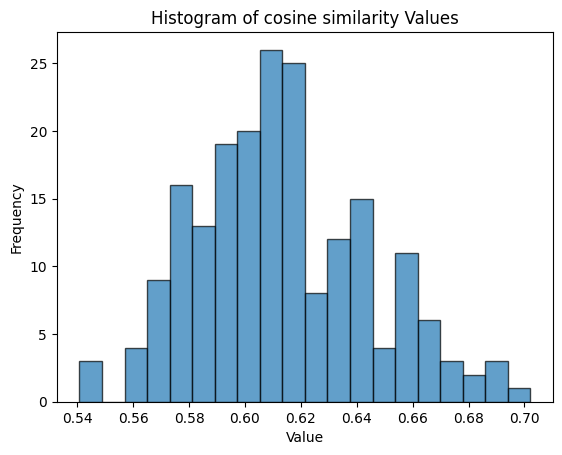

In [5]:
import matplotlib.pyplot as plt

print(similarity_scores.shape)

# Extract the diagonal elements to get the cosine similarity for corresponding vectors
cosine_similarities = np.diag(similarity_scores)

# Verify the shape
print(cosine_similarities.shape)  # Output should be (200,)
print(f"Average Cosine Similarity: {np.mean(similarity_scores)}")

# Calculate histogram data
bins = 20  # Number of bins
hist, bin_edges = np.histogram(cosine_similarities, bins=bins)

#print("Histogram frequencies:", hist)
#print("Bin edges:", bin_edges)

# Plot the histogram
plt.hist(cosine_similarities, bins=bins, edgecolor='black', alpha=0.7)
plt.title("Histogram of cosine similarity Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [6]:
test_feature_matrix.shape

(200, 512, 7, 7)

#### Test Decoding the predicted features against the encoded features

In [1]:
from tensorflow.keras.models import load_model
model = load_model("/home/aditis/decodingEEG/DecodeEEG/data/results/cnn_model_simple_trained.h5")

2025-01-17 15:28:48.824298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-17 15:28:48.886451: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-17 15:28:48.888545: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-17 15:28:48.888556: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

Training EEG single image data shape:
(80, 17, 100)
(Training EEG repetitions × EEG channels × EEG time points)

/home/aditis/decodingEEG/DecodeEEG/data/images/test_images/00001_aircraft_carrier/aircraft_carrier_06s.jpg


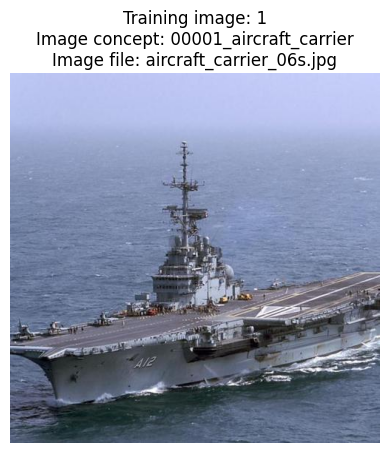

In [2]:
import os
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt

path_to_eeg = "/home/aditis/decodingEEG/DecodeEEG/data/PreprocessedEEG/"
path_to_images = "/home/aditis/decodingEEG/DecodeEEG/data/images/"
test_img_idx =  0 #@param {type:"integer"}
eeg_data_train = np.load(path_to_eeg+"sub-01/preprocessed_eeg_test.npy", allow_pickle=True).item()
img_metadata = np.load(os.path.join(path_to_images, 'image_metadata.npy'),
	allow_pickle=True).item()
eeg_data_single_image = eeg_data_train['preprocessed_eeg_data'][test_img_idx]
print('Training EEG single image data shape:')
print(eeg_data_single_image.shape) # predict spectrograms from this
print('(Training EEG repetitions × EEG channels × EEG time points)\n')

train_img_dir = os.path.join(path_to_images, 'test_images',
	img_metadata['test_img_concepts'][test_img_idx],
	img_metadata['test_img_files'][test_img_idx])
print(train_img_dir)
train_img = Image.open(train_img_dir).convert('RGB') # get features from this

plt.figure()
plt.axis('off')
plt.imshow(train_img)
plt.title('Training image: ' + str(test_img_idx+1) + '\nImage concept: ' +\
	img_metadata['test_img_concepts'][test_img_idx] + '\nImage file: ' +\
	img_metadata['test_img_files'][test_img_idx]);

In [3]:
# Get spectrograms
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import square, ShortTimeFFT
from scipy.signal.windows import gaussian

import sys
from pathlib import Path

# Add the project root to sys.path
project_root = Path("/home/aditis/decodingEEG/DecodeEEG/src/visualize/visualize_predict.ipynb").resolve().parent.parent
sys.path.append(str(project_root))

from eeg_preprocessing import eeg_to_spectrogram

def plot_spectrogram(img_sig):
    Sx2 = eeg_to_spectrogram(img_sig)   # Compute spectrogram

    print(Sx2.shape)

    g_std = 12  # standard deviation for Gaussian window in samples
    win = gaussian(50, std=g_std, sym=True)  # symmetric Gaussian wind.
    T_x, N = 1 / 100, 100  # 100 Hz sampling rate for 1 s signal
    SFT = ShortTimeFFT(win, hop=2, fs=1/T_x,scale_to='psd')
     # Time range for extent
    t_lo, t_hi = SFT.extent(N)[:2]  # Time range of plot

    # Visualize
    # Parameters
    rows, cols = 5, 4  # Grid of subplots (5x4) for 17 plots
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))  # Create subplots

    # Flatten axes array to make it easier to handle
    axes = axes.flatten()


    # Loop over all 17 spectrograms to plot
    for idx in range(Sx2.shape[0]):
        ax = axes[idx]
        Sx = Sx2[idx, :, :]
        Sx_dB = 10 * np.log10(np.fmax(Sx, 1e-4))  # Limit range to -40 dB
        
        # Plot spectrogram
        im = ax.imshow(Sx_dB, origin='lower', aspect='auto',
                    extent=SFT.extent(N), cmap='magma')
        
        # Title and labels
        ax.set_title(f"Channel {idx + 1}")
        ax.set_xlim(t_lo, t_hi)
        ax.legend()

    # Hide any unused subplots
    for ax in axes[Sx2.shape[0]:]:
        ax.axis('off')

    # Add colorbar to the figure
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Position for colorbar
    fig.colorbar(im, cax=cbar_ax, label='Power Spectral Density (dB)')

    fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar
    plt.show()

(17, 26, 26)


/tmp/ipykernel_119436/229237088.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/tmp/ipykernel_119436/229237088.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit colorbar


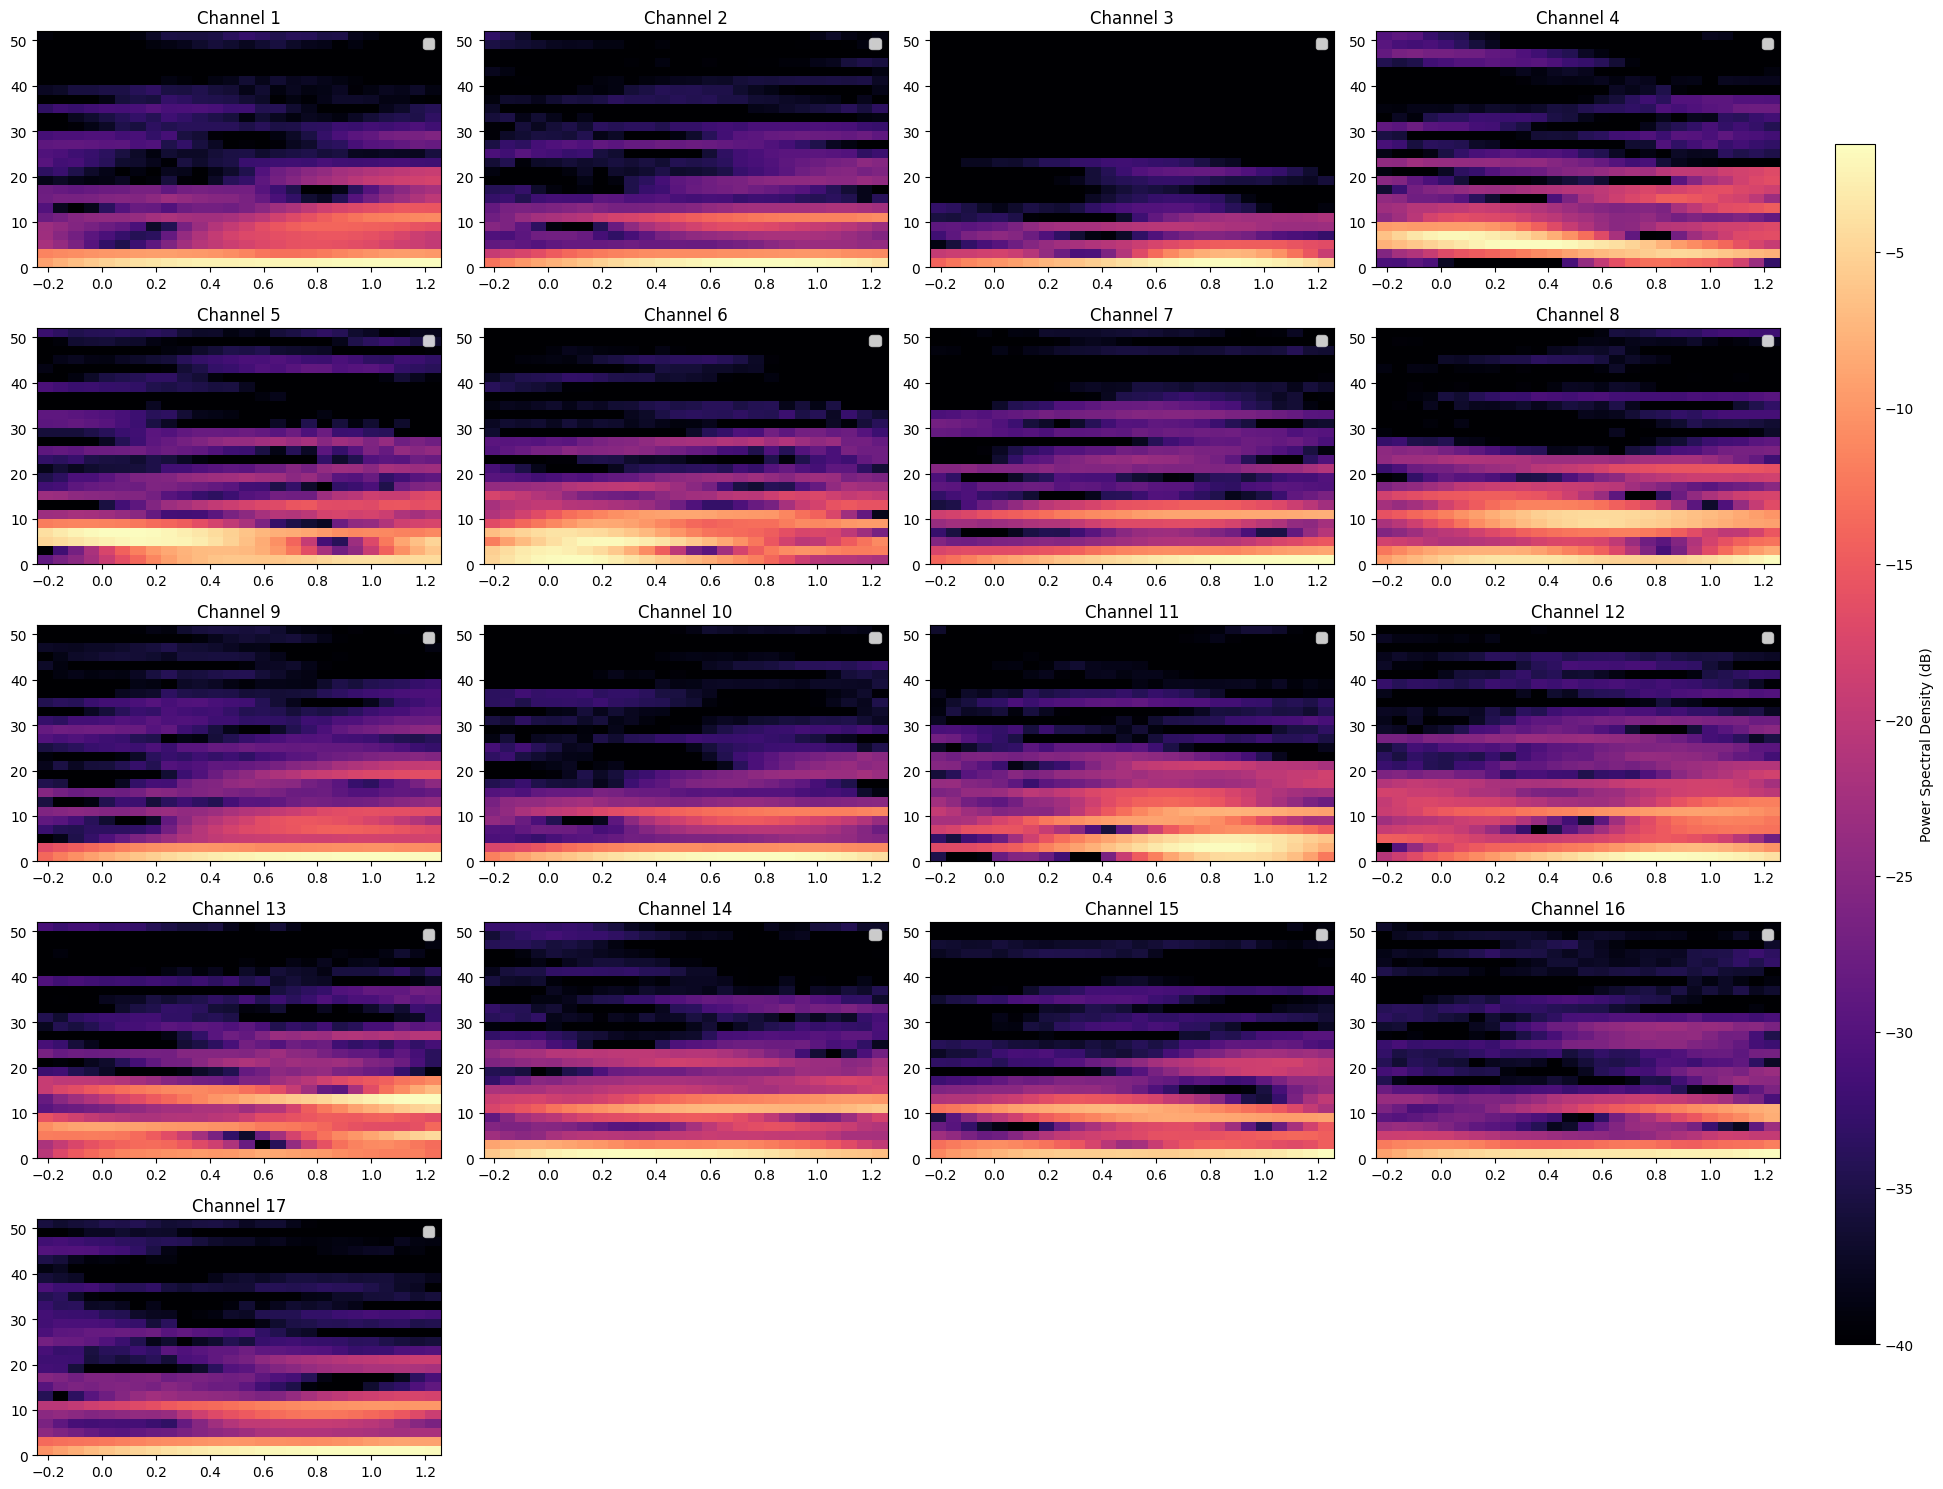

In [4]:
plot_spectrogram(eeg_data_single_image[0,:,:]) 

In [5]:
# get all spectrograms (80, 17, 26, 26)

eeg_spec_all = []

for i in range(eeg_data_single_image.shape[0]):
    eeg_spec_all.append(eeg_to_spectrogram(eeg_data_single_image[i,:,:]))

eeg_spec_all = np.array(eeg_spec_all)
print(eeg_spec_all.shape)

(80, 17, 26, 26)


In [6]:
# Get all predictions from the above EEG
predicted_features_all = []

for i in range(eeg_spec_all.shape[0]):
    eeg_spec = eeg_spec_all[i,:,:,:]
    eeg_spec = np.expand_dims(eeg_spec, axis=0)
    eeg_spec = eeg_spec.astype('float32')
    eeg_spec = eeg_spec/255.0
    print(eeg_spec.shape)
    pred = model.predict(eeg_spec)
    predicted_features_all.append(pred)

predicted_features_all = np.array(predicted_features_all)
print(predicted_features_all.shape)

(1, 17, 26, 26)
1/1 [==============================] - 0s 146ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 96ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 96ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 96ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 96ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 96ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 96ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 95ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 99ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 95ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 96ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 95ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 95ms/step
(1, 17, 26, 26)
1/1 [==============================] - 0s 96ms/step
(1, 17, 26, 26)
1/1 [==========================

In [7]:
import sys
from pathlib import Path

# Add the project root to sys.path
project_root = Path("/home/aditis/decodingEEG/DecodeEEG/src").resolve()
sys.path.append(str(project_root))

from img_preprocessing.decode import Decoder
from img_preprocessing.encode import Encoder


=> torch version : 2.5.1+cu124
=> modeling the network ...
=> num of params: 22357248 (85M)
=> loading pth from /home/aditis/decodingEEG/DecodeEEG/data/results/caltech256-resnet18.pth ...


/home/aditis/decodingEEG/DecodeEEG/src/img_preprocessing/utils.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(resume_path)


=> completed decoder initilization ...
=> torch version : 2.5.1+cu124
=> modeling the network ...
=> num of params: 22357248 (85M)
=> loading pth from /home/aditis/decodingEEG/DecodeEEG/data/results/caltech256-resnet18.pth ...
=> completed decoder initilization ...
(500, 500)
(1, 512, 7, 7)


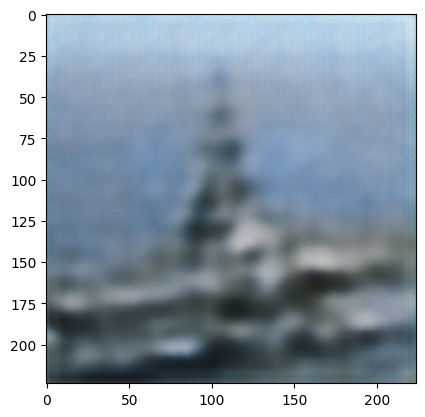

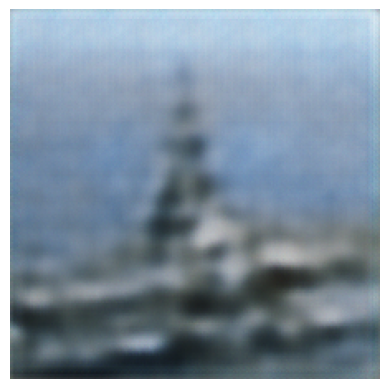

In [8]:
Decoder = Decoder()
Encoder = Encoder()

# get encoded feature of the image
print(train_img.size)
code = Encoder.encode(train_img_dir)    # Encode the image

# get decoded image from the encoded feature
decoded_img = Decoder.decode(code)  # Decode the image

# Display the decoded image
plt.figure()
plt.axis('off')
plt.imshow(decoded_img)

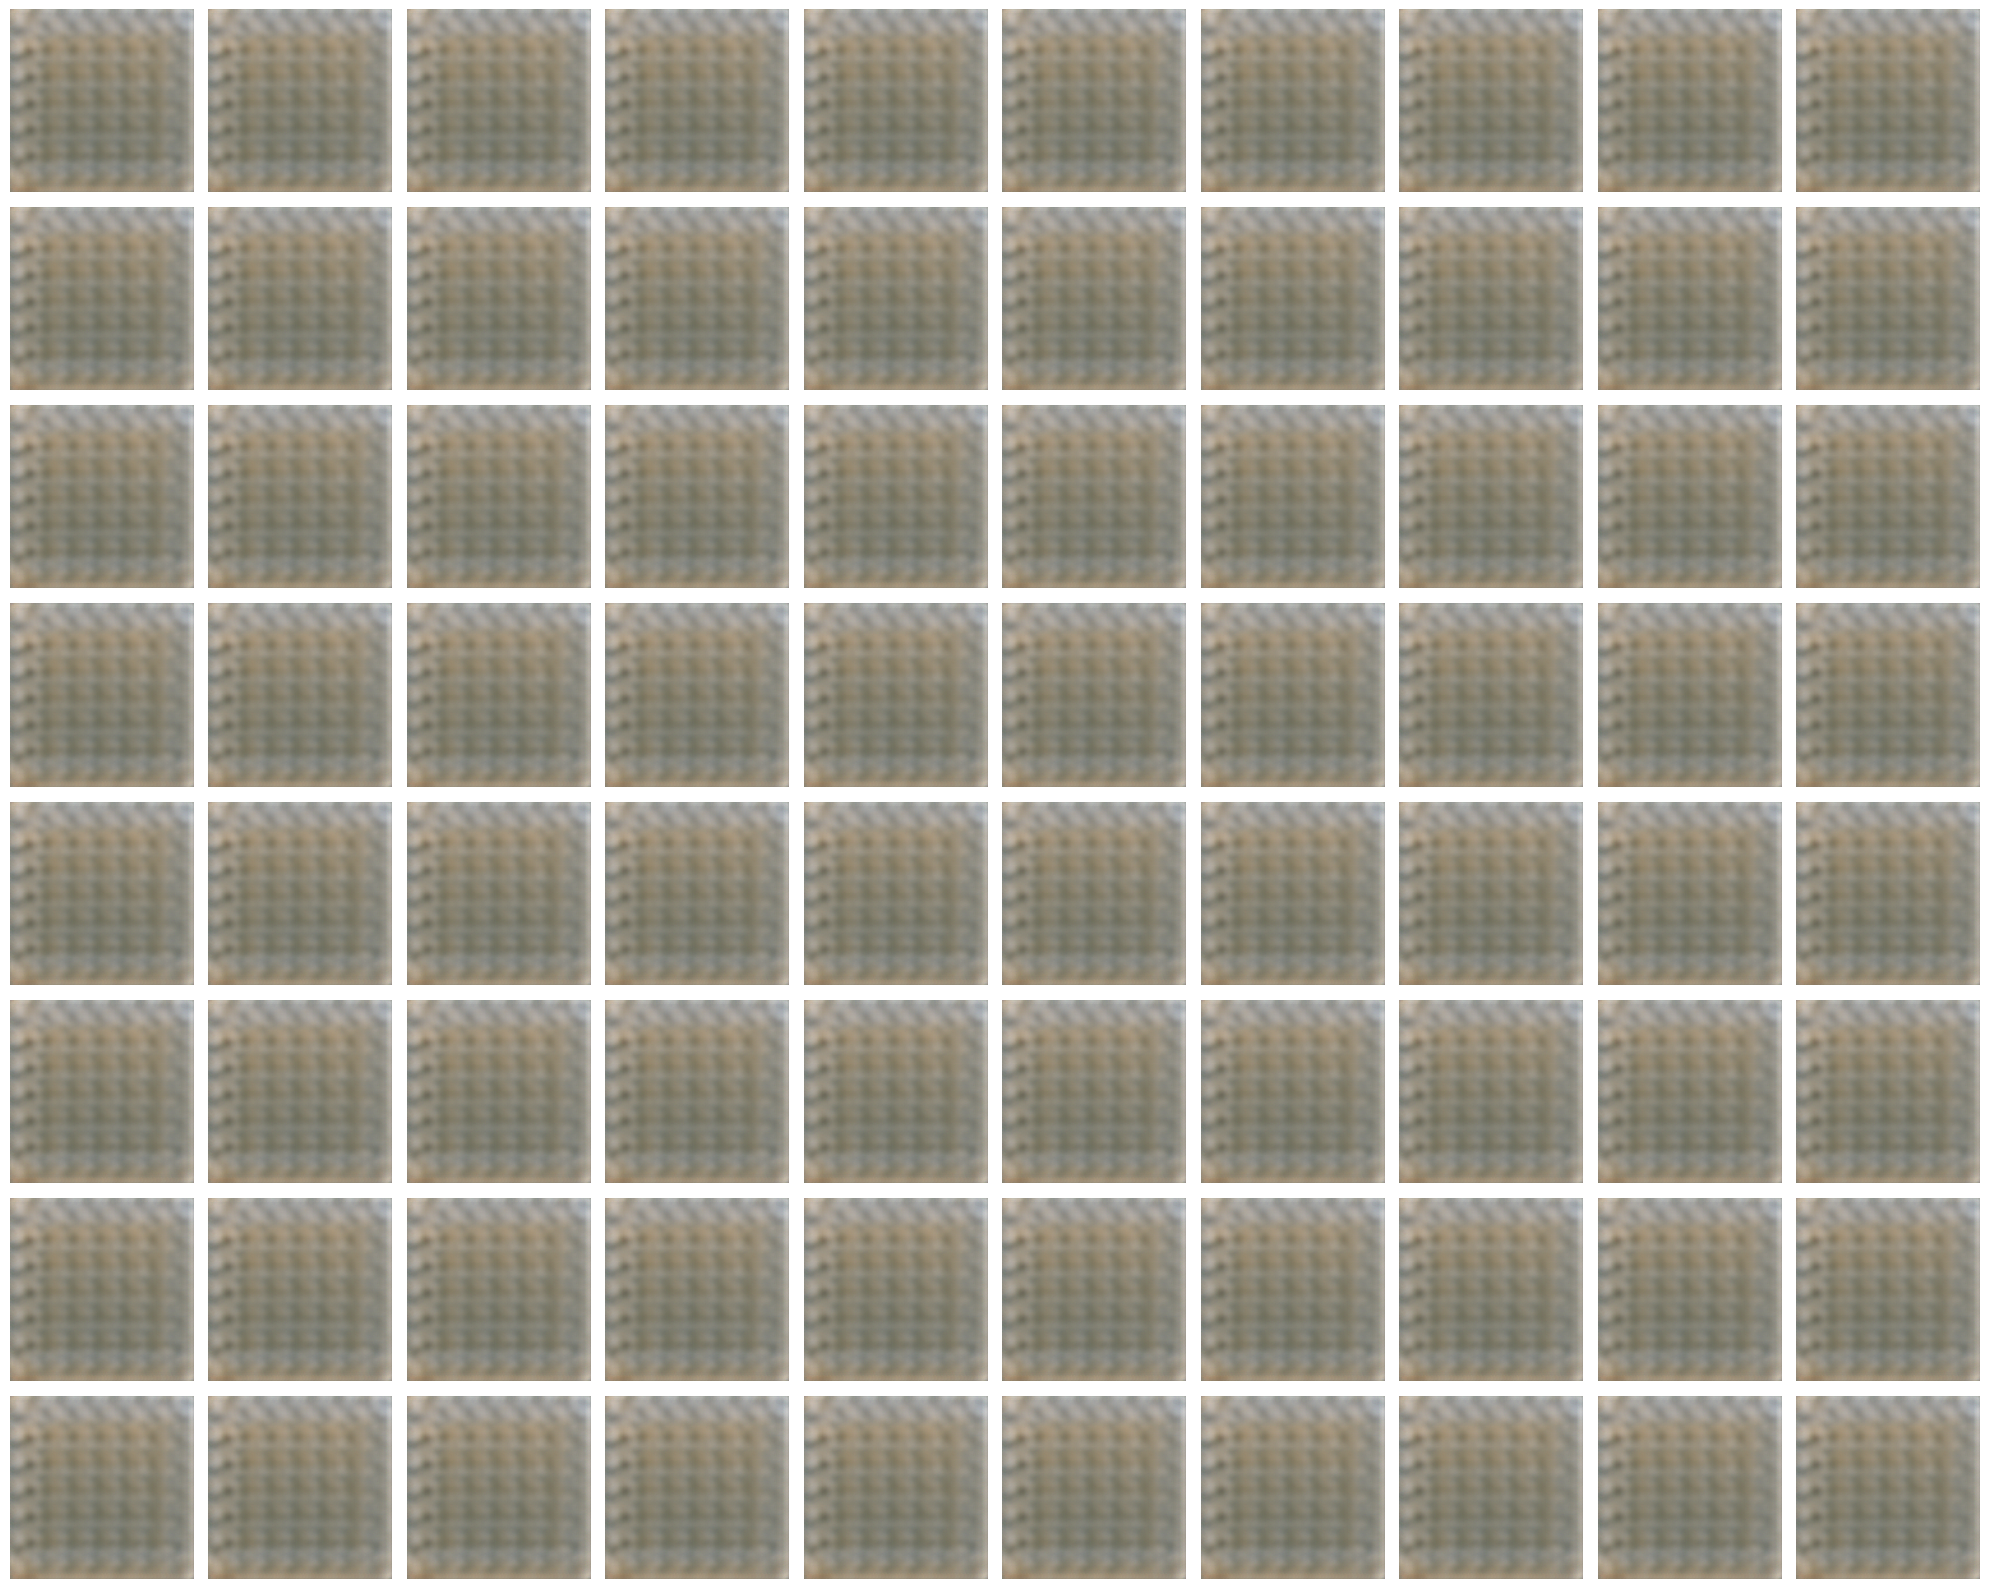

In [15]:
# Create an 8x10 grid of subplots
fig, axes = plt.subplots(8, 10, figsize=(20, 16))

# Populate the subplots in a loop
for i, ax in enumerate(axes.flat):
    code = predicted_features_all[i]  # Get the encoded feature
    decoded_img = Decoder.decode(code)  # Decode the image
    ax.imshow(decoded_img, cmap='gray')
    ax.axis('off')  # Hide the axes

# Adjust layout
plt.tight_layout()
plt.show()
